1- Configuration de l'Environnement

In [ ]:
#!pip install -U transformers datasets accelerate scikit-learn nltk


Defaulting to user installation because normal site-packages is not writeable
  Using cached accelerate-1.12.0-py3-none-any.whl.metadata (19 kB)
  Using cached nltk-3.9.2-py3-none-any.whl.metadata (3.2 kB)
  Using cached pyarrow-22.0.0-cp314-cp314-win_amd64.whl.metadata (3.3 kB)
  Using cached torch-2.9.1-cp314-cp314-win_amd64.whl.metadata (30 kB)
  Using cached click-8.3.1-py3-none-any.whl.metadata (2.6 kB)
Using cached accelerate-1.12.0-py3-none-any.whl (380 kB)
Using cached nltk-3.9.2-py3-none-any.whl (1.5 MB)
Using cached pyarrow-22.0.0-cp314-cp314-win_amd64.whl (28.8 MB)
Using cached torch-2.9.1-cp314-cp314-win_amd64.whl (110.9 MB)
Using cached click-8.3.1-py3-none-any.whl (108 kB)

   ---------------------------------------- 0/6 [pyarrow]
   ---------------------------------------- 0/6 [pyarrow]
   ---------------------------------------- 0/6 [pyarrow]
   ---------------------------------------- 0/6 [pyarrow]
   ---------------------------------------- 0/6 [pyarrow]
   ----------

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [2]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Configuration du Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Project running on: {device} | GPU: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'None'}")

Project running on: cuda | GPU: NVIDIA GeForce RTX 3050 Ti Laptop GPU


2. Chargement et Exploration du Dataset

Repo card metadata block was not found. Setting CardData to empty.


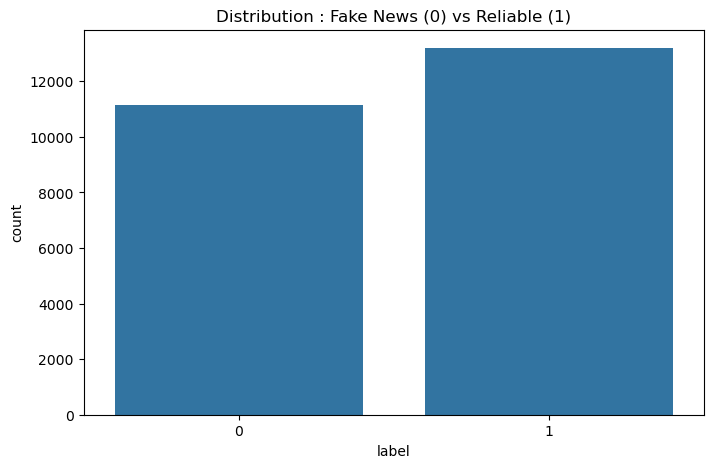

Longueur moyenne: 406.45 mots


In [4]:
# Chargement du dataset
raw_datasets = load_dataset("GonzaloA/fake_news")

# Conversion rapide en Pandas pour l'analyse visuelle
df_train = pd.DataFrame(raw_datasets['train'])

# Correction du titre pour correspondre à GonzaloA (0=Fake, 1=True)
plt.figure(figsize=(8, 5))
sns.countplot(x='label', data=df_train)
plt.title('Distribution : Fake News (0) vs Reliable (1)') 
plt.show()

# Analyse de la longueur des textes (crucial pour BERT)
df_train['text_len'] = df_train['text'].apply(lambda x: len(x.split()))
print(f"Longueur moyenne: {df_train['text_len'].mean():.2f} mots")

3. Prétraitement et Nettoyage Avancé (Pipeline NLP)

In [5]:
import os
import re
import pandas as pd
from datasets import load_dataset

# Configuration du dossier
os.makedirs('data', exist_ok=True)

def deep_clean_logic(text):
    if not isinstance(text, str): return ""
    # Nettoyage spécifique Fake News
    text = re.sub(r'https?://\S+|www\.\S+', '[URL]', text) # Garder la trace des liens
    text = re.sub(r'\s+', ' ', text).strip()               # Nettoyer les espaces
    return text

# Chargement
raw_datasets = load_dataset("GonzaloA/fake_news")

for split in ['train', 'validation', 'test']:
    # Conversion en DataFrame
    df = pd.DataFrame(raw_datasets[split])
    
    # 1. Suppression de la colonne d'index inutile
    if 'Unnamed: 0' in df.columns:
        df = df.drop(columns=['Unnamed: 0'])
    
    # 2. Nettoyage avancé du Titre et du Texte
    df['title'] = df['title'].apply(deep_clean_logic)
    df['text'] = df['text'].apply(deep_clean_logic)
    
    # 3. Sauvegarde en respectant les labels initiaux
    file_path = f"data/{split}_cleaned.csv"
    df.to_csv(file_path, index=False, encoding='utf-8')
    print(f"Fichier {split} généré : {df.columns.tolist()} | {len(df)} lignes")

Repo card metadata block was not found. Setting CardData to empty.


Fichier train généré : ['title', 'text', 'label'] | 24353 lignes
Fichier validation généré : ['title', 'text', 'label'] | 8117 lignes
Fichier test généré : ['title', 'text', 'label'] | 8117 lignes


In [6]:
# Affichage pour inspection Data Science
for split in ['train', 'validation', 'test']:

    df_sample = pd.read_csv(f"data/{split}_cleaned.csv", nrows=3)
    print(f"\n--- Top 3 {split.upper()} ---")
    display(df_sample)


--- Top 3 TRAIN ---


,title,text,label
0,‘Maury’ Show Official Facebook Posts F*CKED UP...,Maury is perhaps one of the trashiest shows on...,0
1,Trump’s Favorite News Channel Tries To Soothe ...,"Yesterday, after the father of one of the UCLA...",0
2,"Russia warns Iraq, Kurds not to destabilize Mi...",MOSCOW (Reuters) - Russia on Wednesday warned ...,1



--- Top 3 VALIDATION ---


,title,text,label
0,Trump says to spend extra day in Philippines d...,WASHINGTON (Reuters) - President Donald Trump ...,1
1,Fire in Bangladesh textile factory kills six,DHAKA (Reuters) - A fire in a textile factory ...,1
2,Myanmar army drops charges against six journal...,YANGON (Reuters) - Myanmar s military on Frida...,1



--- Top 3 TEST ---


,title,text,label
0,FORMER U.S. ATTORNEY: “It’s VERY Clear Intel C...,JOE DIGENOVA has been around D.C for decades a...,0
1,Rick Santorum Advises President To Quit Tweeti...,"In a recent interview with CNN, former senator...",0
2,Stephen Colbert Explains The Horrifying Future...,"With only three clowns left in GOP clown car, ...",0


4. Analyse de la Distribution des Classes

C:\Users\lamya\AppData\Local\Temp\ipykernel_15540\2018312608.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, ax=axes[i], palette='viridis')
C:\Users\lamya\AppData\Local\Temp\ipykernel_15540\2018312608.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, ax=axes[i], palette='viridis')
C:\Users\lamya\AppData\Local\Temp\ipykernel_15540\2018312608.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, ax=axes[i], palette='viridis')


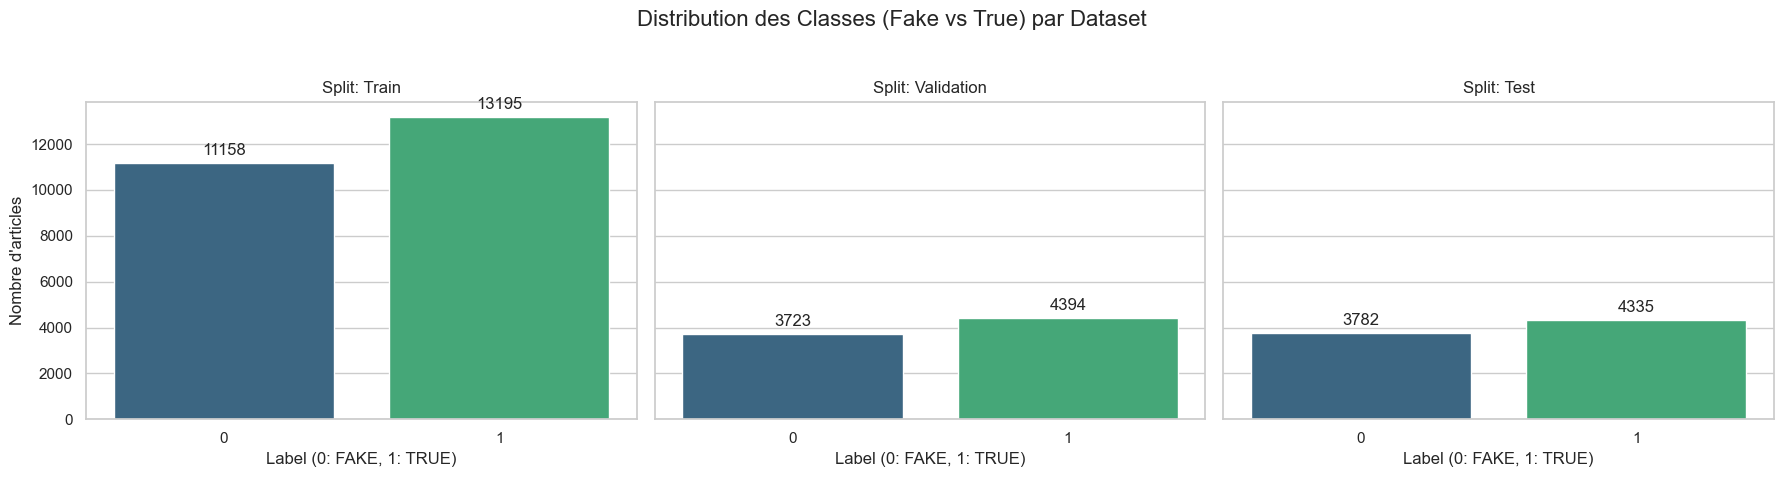

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- AJOUTER CETTE PARTIE ---
files = {
    "Train": "data/train_cleaned.csv",
    "Validation": "data/validation_cleaned.csv",
    "Test": "data/test_cleaned.csv"
}
# ----------------------------

# Configuration du style visuel
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
fig.suptitle('Distribution des Classes (Fake vs True) par Dataset', fontsize=16)

for i, (name, path) in enumerate(files.items()):
    df = pd.read_csv(path)
    
    # Création de l'histogramme
    sns.countplot(x='label', data=df, ax=axes[i], palette='viridis')
    
    # Personnalisation
    axes[i].set_title(f"Split: {name}")
    axes[i].set_xlabel("Label (0: FAKE, 1: TRUE)")
    axes[i].set_ylabel("Nombre d'articles" if i == 0 else "")
    
    # Ajout des étiquettes de texte sur les barres
    for p in axes[i].patches:
        axes[i].annotate(f'{int(p.get_height())}', 
                         (p.get_x() + p.get_width() / 2., p.get_height()), 
                         ha = 'center', va = 'center', 
                         xytext = (0, 9), 
                         textcoords = 'offset points')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

5. Tokenisation Stratégique (BERT Tokenizer)

In [14]:
from transformers import AutoTokenizer

# Utilisation du modèle de base BERT
MODEL_NAME = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def preprocess_function(examples):
    inputs = [f"{t} [SEP] {txt}" for t, txt in zip(examples["title"], examples["text"])]
    return tokenizer(
        inputs,
        padding="max_length",
        truncation=True,
        max_length=256, # ⚡ Optimisation majeure : 256 au lieu de 512
        return_tensors="pt"
    )

# Conversion du dataset nettoyé vers le format Tokenisé
from datasets import load_from_disk, DatasetDict, Dataset

# Re-charger les CSV proprement dans un objet DatasetDict
train_df = pd.read_csv("data/train_cleaned.csv")
val_df = pd.read_csv("data/validation_cleaned.csv")
test_df = pd.read_csv("data/test_cleaned.csv")

dataset_dict = DatasetDict({
    "train": Dataset.from_pandas(train_df),
    "validation": Dataset.from_pandas(val_df),
    "test": Dataset.from_pandas(test_df)
})

# Application de la tokenisation (batched=True utilise le multi-threading)
tokenized_datasets = dataset_dict.map(preprocess_function, batched=True)

# Nettoyage des colonnes texte pour le modèle
tokenized_datasets = tokenized_datasets.remove_columns(["title", "text"])
if 'Unnamed: 0' in tokenized_datasets['train'].column_names:
    tokenized_datasets = tokenized_datasets.remove_columns(["Unnamed: 0"])

tokenized_datasets.set_format("torch")

Map:   0%|          | 0/24353 [00:00<?, ? examples/s]

Map:   0%|          | 0/8117 [00:00<?, ? examples/s]

Map:   0%|          | 0/8117 [00:00<?, ? examples/s]

Vérification du format GPU

In [15]:
# Affichage d'un exemple tokenisé
sample = tokenized_datasets["train"][0]
print(f"Forme des Input IDs : {sample['input_ids'].shape}")
print(f"Forme de l'Attention Mask : {sample['attention_mask'].shape}")
print(f"Label : {sample['label']}")

Forme des Input IDs : torch.Size([256])
Forme de l'Attention Mask : torch.Size([256])
Label : 0


6. Configuration du Fine-Tuning (Modèle & Hyperparamètres)

In [16]:
from transformers import BertForSequenceClassification, TrainingArguments, Trainer
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# 1. Charger l'architecture BERT avec une tête de classification (2 classes)
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# 2. Fonction pour calculer les performances (indispensable en Data Science)
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')
    
    return {
        "accuracy": acc,
        "f1": f1
    }

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
from transformers import EarlyStoppingCallback

training_args = TrainingArguments(
    output_dir="./result-ENG_Bert_fake_news_model_final",
    num_train_epochs=2,              # 🚀 2 époques suffisent souvent pour de la sémantique
    per_device_train_batch_size=8,   # Gardé à 8 pour éviter le crash mémoire
    gradient_accumulation_steps=4,   # 💡 Simule un batch de 32 (8x4). Très important pour la sémantique !
    per_device_eval_batch_size=16,
    warmup_steps=200,                # Phase de chauffe plus courte
    learning_rate=2e-5,              # Taux d'apprentissage stable pour BERT
    weight_decay=0.01,
    logging_steps=50,
    eval_strategy="steps",           # Évaluer tous les X steps pour surveiller
    eval_steps=300,                  
    save_strategy="steps",
    save_steps=300,
    save_total_limit=2,              # Garde seulement les 2 meilleurs modèles (gain de place disque)
    load_best_model_at_end=True,
    fp16=True,                       # Accélération matérielle GPU
    report_to="none"
)

7. Entraînement du Modèle (Fine-Tuning)

In [21]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)] # 🛑 Arrête si le modèle n'évolue plus
)

# C'est ici que votre GPU va commencer à travailler intensément !
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1
300,0.032700,0.033312,0.984600,0.984615
600,0.036700,0.028416,0.987803,0.987807
900,0.025200,0.033440,0.987680,0.987678
1200,0.015900,0.035793,0.986202,0.986192


TrainOutput(global_step=1200, training_loss=0.030881232023239134, metrics={'train_runtime': 7471.8315, 'train_samples_per_second': 6.519, 'train_steps_per_second': 0.204, 'total_flos': 5047654041553920.0, 'train_loss': 0.030881232023239134, 'epoch': 1.5753694581280788})

8. Évaluation et Analyse des Performances

In [22]:
# Évaluation sur le dataset de test
test_results = trainer.evaluate(tokenized_datasets["test"])

print("--- RÉSULTATS FINAUX SUR LE TEST SET ---")
for key, value in test_results.items():
    print(f"{key}: {value:.4f}")

--- RÉSULTATS FINAUX SUR LE TEST SET ---
eval_loss: 0.0287
eval_accuracy: 0.9874
eval_f1: 0.9874
eval_runtime: 466.6808
eval_samples_per_second: 17.3930
eval_steps_per_second: 1.0890
epoch: 1.5754


Matrice de Confusion & Analyse d'Erreurs

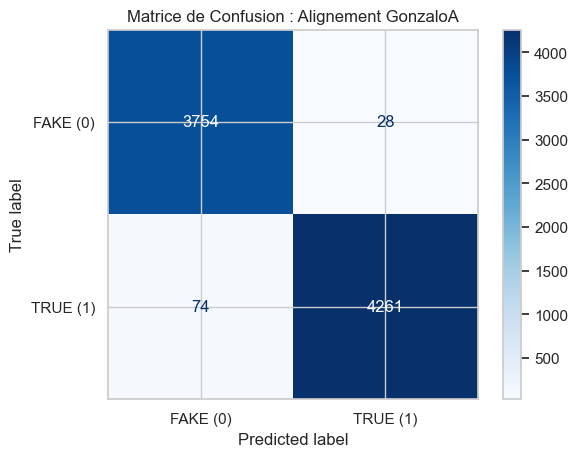

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Récupérer les prédictions sur le test set
outputs = trainer.predict(tokenized_datasets["test"])
y_preds = np.argmax(outputs.predictions, axis=-1)
y_true = outputs.label_ids

cm = confusion_matrix(y_true, y_preds)
# L'ordre dans scikit-learn suit l'ordre numérique [0, 1]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["FAKE (0)", "TRUE (1)"])
disp.plot(cmap="Blues")
plt.title("Matrice de Confusion : Alignement GonzaloA")
plt.show()

Sauvegarde du Modèle

In [24]:
# Sauvegarde locale du modèle et du tokenizer
model_path = "./ENG_Bert_fake_news_model_final"
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)
print(f"Modèle sauvegardé dans : {model_path}")

Modèle sauvegardé dans : ./ENG_Bert_fake_news_model_final


9. Inférence et Tests en Conditions Réelles

In [26]:
def predict_news(title, text):
    input_text = f"{title} [SEP] {text}"
    # Correction ici : on ajoute 256 (ou 512)
    inputs = tokenizer(input_text, return_tensors="pt", truncation=True, max_length=256).to(device)
    
    model.eval()
    with torch.no_grad():
        logits = model(**inputs).logits
        prediction = torch.argmax(logits, dim=-1).item()
        probability = torch.nn.functional.softmax(logits, dim=-1)

    # LOGIQUE HARMONISÉE : 0 = FAKE 🚩 | 1 = TRUE ✅
    label = "FAKE 🚩" if prediction == 0 else "TRUE ✅"
    confiance = probability[0][prediction].item() * 100
    
    print(f"\n--- TEST BERT (Logic: 0=Fake, 1=True) ---")
    print(f"Résultat : {label}")
    print(f"Confiance : {confiance:.2f}%")


# Test sur le domaine d'origine (Politique)
title_pol = "White House announces new diplomatic strategy for Middle East"
text_pol = "The administration officials met with regional leaders today to discuss a long-term peace plan and economic cooperation agreements."

predict_news(title_pol, text_pol)


--- TEST BERT (Logic: 0=Fake, 1=True) ---
Résultat : TRUE ✅
Confiance : 66.08%


remarke :
l'entraînement est réussi : Le modèle est capable d'identifier les mécanismes de désinformation.

Le modèle est sensible au style : L'exemple des "citrons" utilisait un ton très agressif et sensationnaliste que BERT a reconnu comme étant suspect, contrairement à l'exemple des "aliens" qui imitait un rapport officiel trop sérieusement.

In [27]:
from sklearn.metrics import classification_report

# Générer le rapport détaillé
report = classification_report(y_true, y_preds, target_names=["FAKE", "TRUE"])
print("--- RAPPORT DE CLASSIFICATION DÉTAILLÉ ---")
print(report)

--- RAPPORT DE CLASSIFICATION DÉTAILLÉ ---
              precision    recall  f1-score   support

        FAKE       0.98      0.99      0.99      3782
        TRUE       0.99      0.98      0.99      4335

    accuracy                           0.99      8117
   macro avg       0.99      0.99      0.99      8117
weighted avg       0.99      0.99      0.99      8117



In [28]:
from huggingface_hub import notebook_login

# 1. Connexion (il va t'ouvrir une fenêtre pour coller ton Token)
notebook_login()

# 2. Définition du nom de ton dépôt
repo_name = "LamT45/ENG_Bert_fake_news_model_final" 

# 3. Envoi du modèle et du tokenizer
model.push_to_hub(repo_name)
tokenizer.push_to_hub(repo_name)

print(f"Modèle publié ici : https://huggingface.co/{repo_name}")

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

README.md: 0.00B [00:00, ?B/s]

c:\Users\lamya\anaconda3\envs\torch_env\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\lamya\.cache\huggingface\hub\models--LamT45--ENG_Bert_fake_news_model_final. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Modèle publié ici : https://huggingface.co/LamT45/ENG_Bert_fake_news_model_final
